# **Set Up**

In [ ]:
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import pandas as pd
import datetime
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_selector
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, roc_auc_score, f1_score, recall_score, classification_report
from imblearn.over_sampling import SMOTE
from collections import Counter
# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.tools as tls
import plotly.offline as py

# **Data**

In [ ]:
df=pd.read_csv('credit_risk_dataset.csv')

In [ ]:
df

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26


In [ ]:
# Show the oldest ages
oldest_ages = df['person_age'].unique()
oldest_ages = sorted(oldest_ages, reverse=True)[:20]
print(oldest_ages)

[144, 123, 94, 84, 80, 78, 76, 73, 70, 69, 67, 66, 65, 64, 63, 62, 61, 60, 59, 58]


In [ ]:
# Show the youngest ages
youngest_ages = df['person_age'].unique()
youngest_ages = sorted(youngest_ages)[:20]

print(youngest_ages)

[20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]


Jeanne Calment, according to the Guinness Book of World Records, had the  longest human lifespan of 122 years and 164 days. We think it's best to remove cases where the person age is greater than 100, considering that it's both impossible in our current state for a person to live longer than 122 years, and inconceivable that banks would issue loans to someone in their 100's.

In [ ]:
# Abolish Necromancy
df = df[df['person_age'] <= 100]
oldest_ages_check = sorted(df['person_age'].unique(), reverse=True)[:20]
print(oldest_ages_check)

[94, 84, 80, 78, 76, 73, 70, 69, 67, 66, 65, 64, 63, 62, 61, 60, 59, 58, 57, 56]


In [ ]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    grab_col_names for given dataframe

    :param dataframe:
    :param cat_th:
    :param car_th:
    :return:
    """

    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, cat_but_car, num_cols

cat_cols, cat_but_car, num_cols = grab_col_names(df)

Observations: 32576
Variables: 12
cat_cols: 5
num_cols: 7
cat_but_car: 0
num_but_cat: 1


In [ ]:
df.isnull().sum().sort_values(ascending=False).head()

loan_int_rate            3115
person_emp_length         895
person_age                  0
person_income               0
person_home_ownership       0
dtype: int64

In [ ]:
df["loan_int_rate"].describe()
df["person_emp_length"].describe()

count    31681.000000
mean         4.789527
std          4.142706
min          0.000000
25%          2.000000
50%          4.000000
75%          7.000000
max        123.000000
Name: person_emp_length, dtype: float64

In [ ]:
# Check for Outliers
def outlier_thresholds(dataframe, variable, low_quantile=0.10, up_quantile=0.90):
    quantile_one = dataframe[variable].quantile(low_quantile)
    quantile_three = dataframe[variable].quantile(up_quantile)
    interquantile_range = quantile_three - quantile_one
    up_limit = quantile_three + 1.5 * interquantile_range
    low_limit = quantile_one - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False
for col in num_cols:
    if col != "loan_status":
      print(col, check_outlier(df, col))

person_age True
person_income True
person_emp_length True
loan_amnt False
loan_int_rate False
loan_percent_income True
cb_person_cred_hist_length True


In [ ]:
# exclude rows whose work experience is >122 (Assuming average Upper bound of employement).
df = df.drop(df[df['person_emp_length'] > 122].index)

Loan interest rate and person employment length have missing values, but because loan interest rate has no outliers and person employment length has outliers, we would move on with our analysis using mean for the missing values of loan interest rate and median for the missing values of person employment length.

In [ ]:
# Dataset where null values are removed

df_1 = df.dropna(subset=['person_emp_length','loan_int_rate'])
df_1.isnull().sum().sort_values(ascending=False).head()

person_age               0
person_income            0
person_home_ownership    0
person_emp_length        0
loan_intent              0
dtype: int64

In [ ]:
mean_value_int = round(df["loan_int_rate"].mean(), 2)
median_value_int = round(df["loan_int_rate"].median(), 2)
mode_value_int = df["loan_int_rate"].mode()[0]  # mode() returns a Series, get the first value with [0]

print("Mean:", mean_value_int)
print("Median:", median_value_int)
print("Mode:", mode_value_int)

Mean: 11.01
Median: 10.99
Mode: 7.51


In [ ]:
mean_value_emp_length = round(df["person_emp_length"].mean(), 2)
median_value_emp_length = round(df["person_emp_length"].median(), 2)
mode_value_emp_length = df["person_emp_length"].mode()[0]  # mode() returns a Series, get the first value with [0]

print("Mean employment length:", mean_value_emp_length)
print("Median employment length:", median_value_emp_length)
print("Mode employment length:", mode_value_emp_length)

Mean employment length: 4.78
Median employment length: 4.0
Mode employment length: 0.0


In [ ]:
#dataset with mean and median values for blank values
dfm=df
dfm["loan_int_rate"].fillna(mean_value_int, inplace=True)
dfm["person_emp_length"].fillna(median_value_emp_length, inplace=True)
dfm.describe()
dfm.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

# **Exploratory Data Analysis**

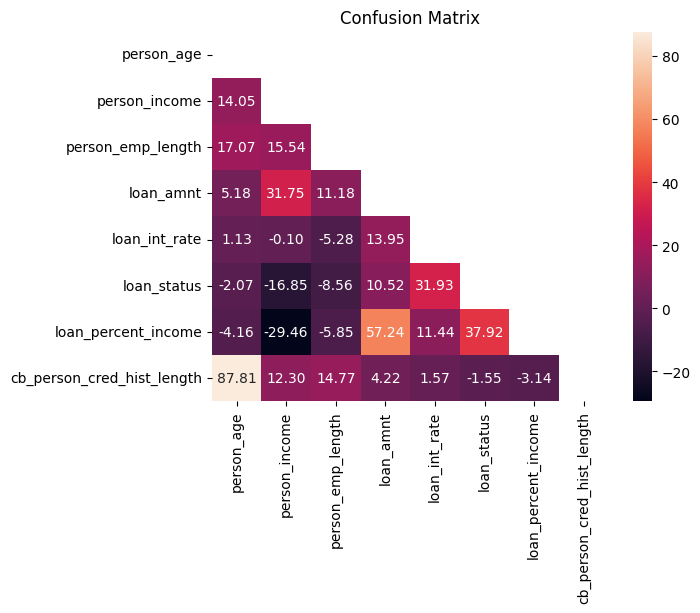

['cb_person_cred_hist_length']

In [ ]:
# Similar to ggpairs from the GGalley in R, this shows the correlation between the numeric variables
def high_correlated_cols(dataframe, plot=False, corr_th=0.70):
    # Select only the numeric columns from the DataFrame
    numeric_dataframe = dataframe.select_dtypes(include=['number'])

    corr = numeric_dataframe.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]

    if plot:
        mask = np.zeros_like(corr)
        mask[np.triu_indices_from(mask)] = True
        sns.heatmap(corr * 100, annot= True, fmt='.2f', mask=mask)
        plt.title('Confusion Matrix')
        plt.show()

    return drop_list

high_correlated_cols(dfm, plot=True)


We are looking for features that are highly correlated with the response
variable and features that are highly correlated with each other. Loan interest rate, loan percent income, person income, and loan amount are highly correlated with loan status. In addition, person income and loan amount are highly correlated with each other, so we might want to investigate potential interaction effect.

In [ ]:
# Target Distribution
temp=dict(layout=go.Layout(font=dict(family="Franklin Gothic", size=12),
                           height=500, width=1000))
target=dfm.loan_status.value_counts(normalize=True)
target.rename(index={1:'Default',0:'non default'},inplace=True)
pal, color=['#016CC9','#DEB078'], ['#8DBAE2','#EDD3B3']
fig=go.Figure()
fig.add_trace(go.Pie(labels=target.index, values=target*100, hole=.45,
                     showlegend=True,sort=False,
                     marker=dict(colors=color,line=dict(color=pal,width=2.5)),
                     hovertemplate = "%{label} Accounts: %{value:.2f}%<extra></extra>"))
fig.update_layout(template=temp, title='Target Distribution',
                  legend=dict(traceorder='reversed',y=1.05,x=0),
                  uniformtext_minsize=15, uniformtext_mode='hide',width=700)
fig.show();

In [ ]:
# Age
df_good = dfm.loc[df["loan_status"] == 1]['person_age'].values.tolist()
df_bad = dfm.loc[df["loan_status"] == 0]['person_age'].values.tolist()
df_age = dfm['person_age'].values.tolist()

#First plot
trace0 = go.Histogram(
    x=df_good,
    histnorm='probability',
    name="Loan status = 1"
)
#Second plot
trace1 = go.Histogram(
    x=df_bad,
    histnorm='probability',
    name="Loan status = 0"
)
#Third plot
trace2 = go.Histogram(
    x=df_age,
    histnorm='probability',
    name="Overall Age"
)
#Creating the grid
fig = tls.make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                          subplot_titles=('Good','Bad', 'General Distribuition'))
fig.update_xaxes(range=[None, 130])
#setting the figs
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig.append_trace(trace2, 2, 1)
fig['layout'].update(showlegend=True, title='Age Distribuition', bargap=0.05)
py.iplot(fig, filename='custom-sized-subplot-with-subplot-titles')

/usr/local/lib/python3.10/dist-packages/plotly/tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [ ]:
# Housing
trace0 = go.Bar(
    x = dfm[dfm["loan_status"]== 1]["person_home_ownership"].value_counts().index.values,
    y = dfm[dfm["loan_status"]== 1]["person_home_ownership"].value_counts().values,
    name='Loan status = 1'
)

#Second plot
trace1 = go.Bar(
    x = dfm[dfm["loan_status"]== 0]["person_home_ownership"].value_counts().index.values,
    y = dfm[dfm["loan_status"]== 0]["person_home_ownership"].value_counts().values,
    name="Loan status = 0"
)

data = [trace0, trace1]
layout = go.Layout(
    title='Housing Distribuition'
)


fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='Housing-Grouped')

In [ ]:
# Intent
trace0 = go.Bar(
    x = dfm[dfm["loan_status"]== 1]["loan_intent"].value_counts().index.values,
    y = dfm[dfm["loan_status"]== 1]["loan_intent"].value_counts().values,
    name='Loan status = 1'
)

#Second plot
trace1 = go.Bar(
    x = dfm[dfm["loan_status"]== 0]["loan_intent"].value_counts().index.values,
    y = dfm[dfm["loan_status"]== 0]["loan_intent"].value_counts().values,
    name="Loan status = 0"
)
data = [trace0, trace1]

layout = go.Layout(
    title='Loan intent'
)


fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='Loan intent')

<ipython-input-21-ce569d8c6a2b>:15: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.


<ipython-input-21-ce569d8c6a2b>:16: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.


<ipython-input-21-ce569d8c6a2b>:15: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.


<ipython-input-21-ce569d8c6a2b>:16: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameter

<Figure size 640x480 with 0 Axes>

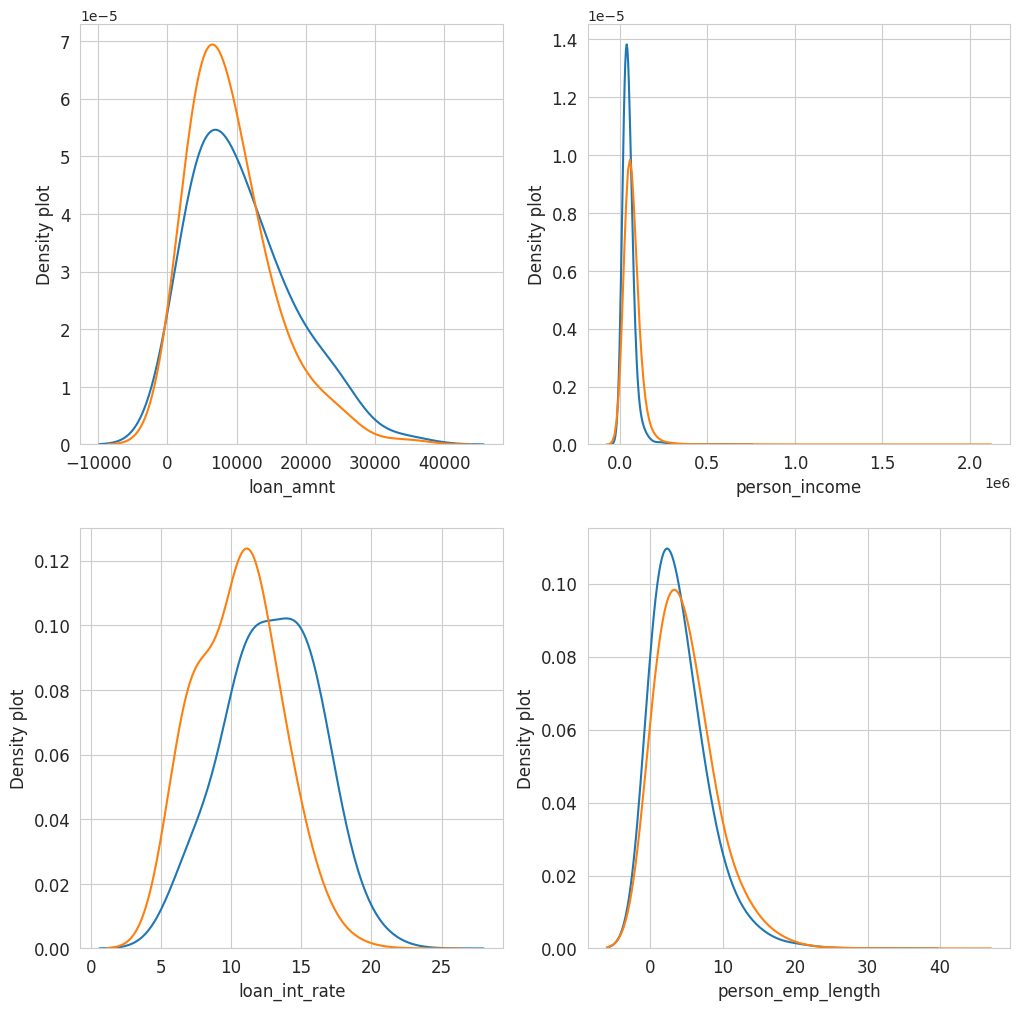

In [ ]:
# Density of quantitative features
def plot_distribution_comp(var,nrow=2):

    i = 0
    t1 = dfm.loc[dfm['loan_status'] != 0]
    t0 = dfm.loc[dfm['loan_status'] == 0]

    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(nrow,2,figsize=(12,6*nrow))

    for feature in var:
        i += 1
        plt.subplot(nrow,2,i)
        sns.kdeplot(t1[feature], bw=0.5,label="TARGET = 1")
        sns.kdeplot(t0[feature], bw=0.5,label="TARGET = 0")
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show();
var = ['loan_amnt','person_income','loan_int_rate', 'person_emp_length']
plot_distribution_comp(var,nrow=2)

# **Model Building**
### Use "dfm" for your models by creating a new df for your section. please do not change dfm.

In [ ]:
dfm

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
5,21,9900,OWN,2.0,VENTURE,A,2500,7.14,1,0.25,N,2
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26


# Setting and Preprocessing

## 1. Preprocessing Pipelines

Numerical features: Standardize using StandardScaler to ensure features have zero mean and unit variance.
Ordinal categorical features: Encode using OrdinalEncoder, then scale using MinMaxScaler.
Nominal categorical features: Encode using OneHotEncoder for one-hot encoding.

Utilize ColumnTransformer to apply different preprocessing pipelines to specified columns.
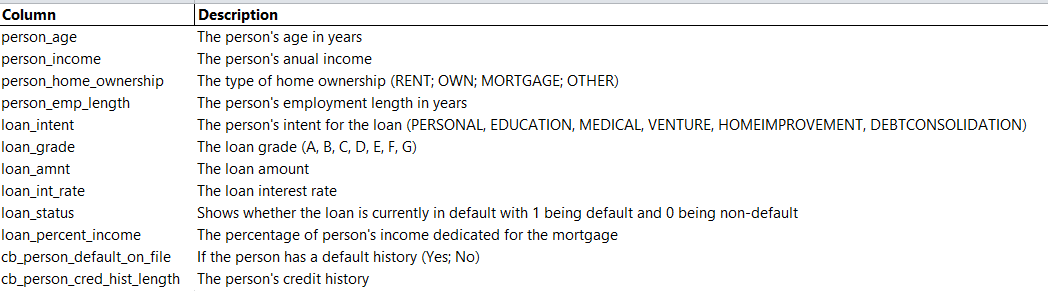

Numerical Features:
Features: 'person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'cb_person_cred_hist_length', 'loan_percent_income'
Transformer: numerical_pipeline, typically including scaling (e.g., StandardScaler).
Reason: Numerical features often require standardization or normalization to ensure that the model does not bias due to different magnitudes of features. For example, the different magnitudes of income (which may range from thousands to hundreds of thousands) and age (which has a smaller range, such as 18 to 80) could affect the learning process of the model, especially when using distance-based algorithms like KNN and SVM, or gradient descent-based algorithms like logistic regression.


Ordinal Features:
Features: 'loan_grade'
Transformer: ordinal_pipeline, including OrdinalEncoder and MinMaxScaler.
Reason: Ordinal features have a natural order or ranking (e.g., loan grades 'A' is better than 'B'). Using OrdinalEncoder preserves this order by converting these categories into a meaningful numerical series. Then, using MinMaxScaler further adjusts these encodings to a range of 0-1, which helps the model, especially in models involving regularization or needing to handle numerical ranges.

Nominal Features:
Features: 'person_home_ownership', 'loan_intent', 'cb_person_default_on_file'
Transformer: nominal_pipeline, including OneHotEncoder.
Reason: Nominal features do not have order or ranking; each category is independent. Using OneHotEncoder converts these categories into binary variables, with each category corresponding to a variable. This encoding method avoids the model incorrectly interpreting numerical values as representing the importance or order between categories. It is suitable for most machine learning models, especially linear models, as they cannot naturally handle categorical data.

In [ ]:
# Define the preprocessing pipeline
# Numerical features
numerical_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

# Ordered classification features
ordinal_pipeline = Pipeline([
    ('encoder', OrdinalEncoder()),
    ('min_max_scaler', MinMaxScaler())
])

# Nominal classification features
nominal_pipeline = Pipeline([
    ('one_hot', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

In [ ]:
ordinal_columns = ['loan_grade']
nominal_columns = ['person_home_ownership', 'loan_intent', 'cb_person_default_on_file']
numerical_columns = ['person_age', 'person_income', 'person_emp_length', 'cb_person_cred_hist_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income']

# Combination Transformer
column_transformer = ColumnTransformer([
    ('numerical', numerical_pipeline, numerical_columns),
    ('ordinal', ordinal_pipeline, ordinal_columns),
    ('nominal', nominal_pipeline, nominal_columns)
], remainder='passthrough')


## 2. Split and Balanced Data with SMOTE


In [ ]:
X = dfm.drop('loan_status', axis=1)  # Features
y = dfm['loan_status']  # Goal

# Split data set into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# Apply preprocessing to the training set and test set
X_train_transformed = column_transformer.fit_transform(X_train)
X_test_transformed = column_transformer.transform(X_test)

# Extract all feature names from ColumnTransformer
feature_names = column_transformer.get_feature_names_out()
X_train_df = pd.DataFrame(X_train_transformed, columns=feature_names)
X_test_df = pd.DataFrame(X_test_transformed, columns=feature_names)
X_train_df
pd.DataFrame({'train':y_train.value_counts(),'test':y_test.value_counts()}).sort_index()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



,train,test
loan_status,,
0,17826,7641
1,4975,2132


In [ ]:
print("Primitive training set class distribution:", Counter(y_train))
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_df, y_train)

print("Post-smote training set class distribution:", Counter(y_train_smote))


Primitive training set class distribution: Counter({0: 17826, 1: 4975})
Post-smote training set class distribution: Counter({0: 17826, 1: 17826})


## 2. Feature Selection



XGBoost builds decision trees through a gradient boosting method, considering the contribution of each feature to reducing model loss. It calculates the gain of each feature split point, where features with higher gains play a more crucial role in the model learning process. Additionally, XGBoost considers the interactions between features during feature selection, which helps capture more complex data patterns that might be missed by other models. By eliminating unimportant features, it reduces model complexity, decreases the risk of overfitting, and enhances the model's generalization ability on unseen data.

### 1. on unbalanced data


                                    Feature  Importance
11      nominal__person_home_ownership_RENT    0.266820
7                       ordinal__loan_grade    0.183307
6            numerical__loan_percent_income    0.109086
12   nominal__loan_intent_DEBTCONSOLIDATION    0.074966
15             nominal__loan_intent_MEDICAL    0.060271
10       nominal__person_home_ownership_OWN    0.057700
14     nominal__loan_intent_HOMEIMPROVEMENT    0.046219
17             nominal__loan_intent_VENTURE    0.042611
1                  numerical__person_income    0.029484
9      nominal__person_home_ownership_OTHER    0.026511
2              numerical__person_emp_length    0.019782
8   nominal__person_home_ownership_MORTGAGE    0.017490
0                     numerical__person_age    0.012982
13           nominal__loan_intent_EDUCATION    0.010511
5                  numerical__loan_int_rate    0.010074
16            nominal__loan_intent_PERSONAL    0.009146
3     numerical__cb_person_cred_hist_length    0

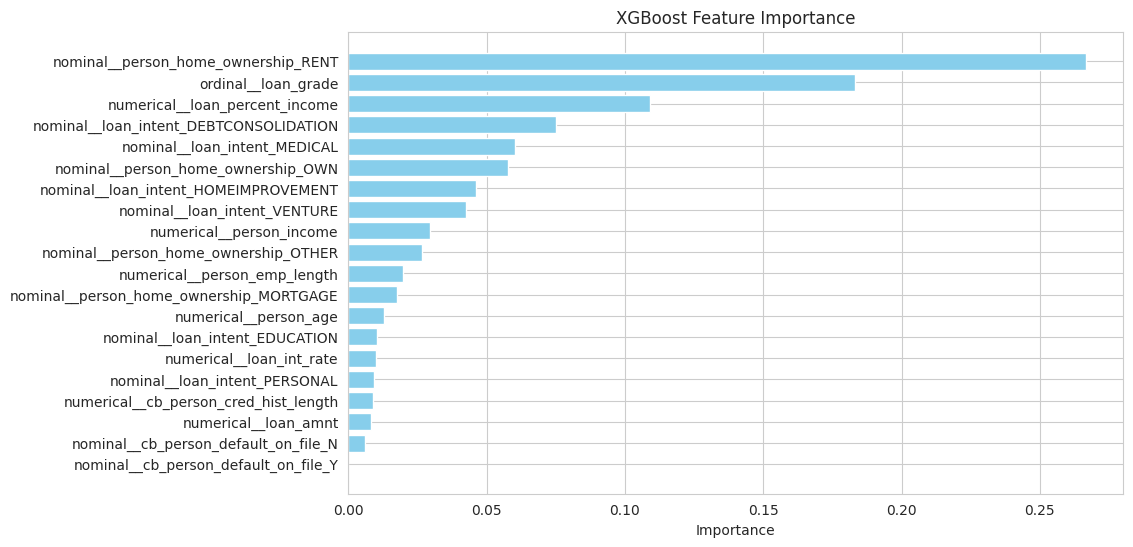

In [ ]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_df, y_train)
# Get feature importance
xgb_importances = xgb_model.feature_importances_

xgb_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_importances
})
xgb_importances_df_sorted = xgb_importances_df.sort_values(by='Importance', ascending=False)
print(xgb_importances_df_sorted)
# Plot a bar chart of feature importance
plt.figure(figsize=(10, 6))
plt.barh(xgb_importances_df_sorted['Feature'], xgb_importances_df_sorted['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('XGBoost Feature Importance')
plt.gca().invert_yaxis()
plt.show()

                                    Feature  Importance
6            numerical__loan_percent_income    0.220636
1                  numerical__person_income    0.143439
7                       ordinal__loan_grade    0.116809
5                  numerical__loan_int_rate    0.108697
4                      numerical__loan_amnt    0.073987
2              numerical__person_emp_length    0.059019
11      nominal__person_home_ownership_RENT    0.051012
0                     numerical__person_age    0.045096
3     numerical__cb_person_cred_hist_length    0.033729
8   nominal__person_home_ownership_MORTGAGE    0.028728
12   nominal__loan_intent_DEBTCONSOLIDATION    0.024251
15             nominal__loan_intent_MEDICAL    0.020959
10       nominal__person_home_ownership_OWN    0.020432
14     nominal__loan_intent_HOMEIMPROVEMENT    0.012223
13           nominal__loan_intent_EDUCATION    0.010160
19     nominal__cb_person_default_on_file_Y    0.008361
16            nominal__loan_intent_PERSONAL    0

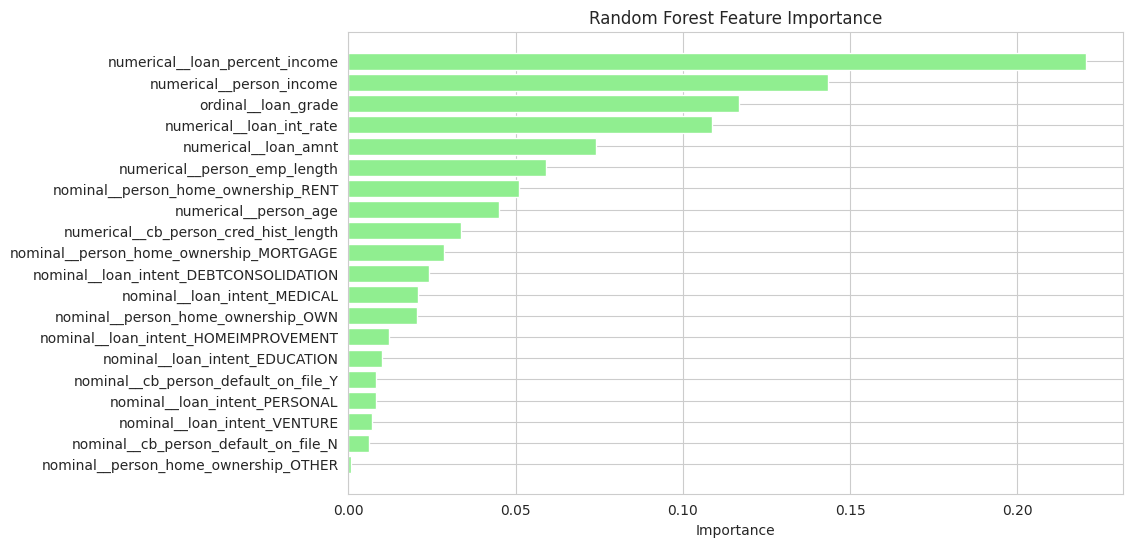

In [ ]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_df, y_train)

rf_importances = rf_model.feature_importances_
rf_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_importances
})

rf_importances_df_sorted = rf_importances_df.sort_values(by='Importance', ascending=False)
print(rf_importances_df_sorted)
# Plot a bar chart of feature importance
plt.figure(figsize=(10, 6))
plt.barh(rf_importances_df_sorted['Feature'], rf_importances_df_sorted['Importance'], color='lightgreen')
plt.xlabel('Importance')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()
plt.show()

### 1. on balanced data


                                    Feature  Importance
7                       ordinal__loan_grade    0.199588
11      nominal__person_home_ownership_RENT    0.183150
6            numerical__loan_percent_income    0.108514
10       nominal__person_home_ownership_OWN    0.095447
15             nominal__loan_intent_MEDICAL    0.056777
17             nominal__loan_intent_VENTURE    0.055812
12   nominal__loan_intent_DEBTCONSOLIDATION    0.048304
14     nominal__loan_intent_HOMEIMPROVEMENT    0.047672
3     numerical__cb_person_cred_hist_length    0.042240
1                  numerical__person_income    0.032490
2              numerical__person_emp_length    0.030117
0                     numerical__person_age    0.023587
8   nominal__person_home_ownership_MORTGAGE    0.021444
13           nominal__loan_intent_EDUCATION    0.013389
16            nominal__loan_intent_PERSONAL    0.013023
4                      numerical__loan_amnt    0.008172
5                  numerical__loan_int_rate    0

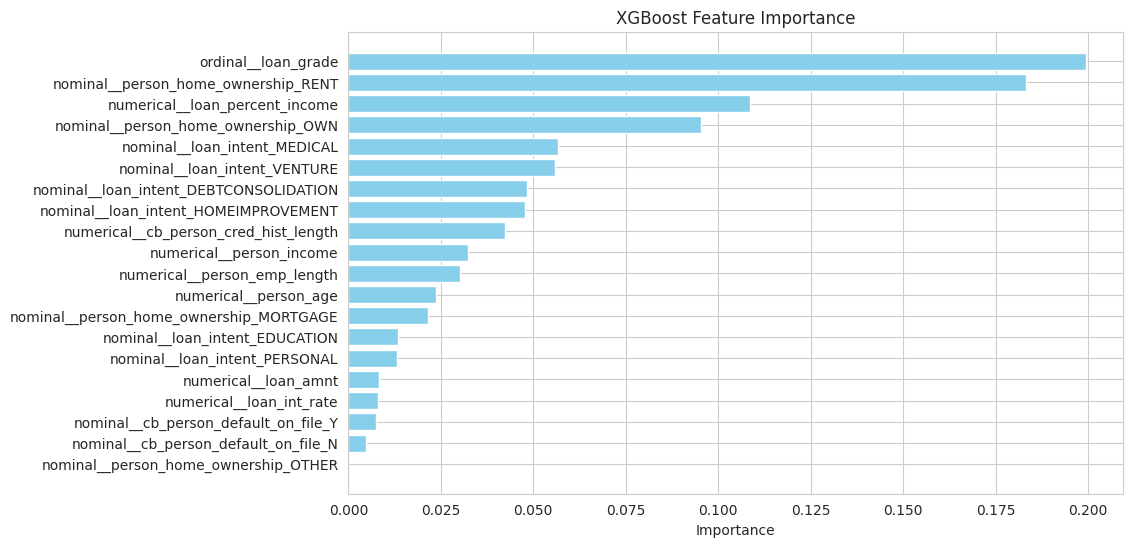

In [ ]:
xgb_model.fit(X_train_smote, y_train_smote)
# Get feature importance
xgb_importances = xgb_model.feature_importances_

xgb_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_importances
})
xgb_importances_df_sorted = xgb_importances_df.sort_values(by='Importance', ascending=False)
print(xgb_importances_df_sorted)

# Plot a bar chart of feature importance
plt.figure(figsize=(10, 6))
plt.barh(xgb_importances_df_sorted['Feature'], xgb_importances_df_sorted['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('XGBoost Feature Importance')
plt.gca().invert_yaxis()
plt.show()

                                    Feature  Importance
6            numerical__loan_percent_income    0.186036
7                       ordinal__loan_grade    0.175333
1                  numerical__person_income    0.132036
5                  numerical__loan_int_rate    0.110117
4                      numerical__loan_amnt    0.070730
2              numerical__person_emp_length    0.052894
0                     numerical__person_age    0.045755
3     numerical__cb_person_cred_hist_length    0.042367
11      nominal__person_home_ownership_RENT    0.042213
8   nominal__person_home_ownership_MORTGAGE    0.026299
10       nominal__person_home_ownership_OWN    0.018977
14     nominal__loan_intent_HOMEIMPROVEMENT    0.016204
12   nominal__loan_intent_DEBTCONSOLIDATION    0.014592
15             nominal__loan_intent_MEDICAL    0.013954
19     nominal__cb_person_default_on_file_Y    0.012411
17             nominal__loan_intent_VENTURE    0.011028
13           nominal__loan_intent_EDUCATION    0

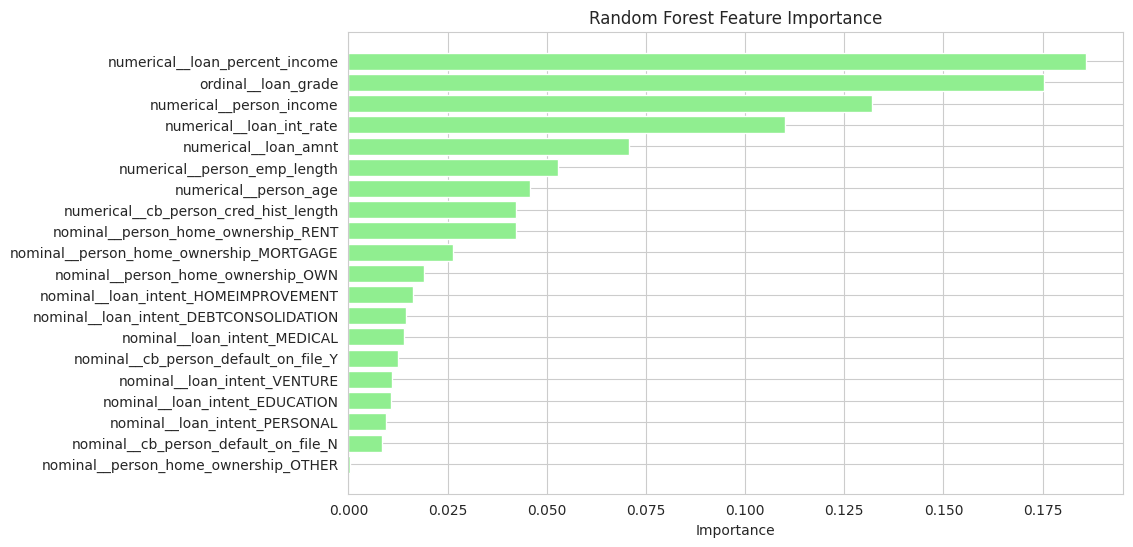

In [ ]:
rf_model.fit(X_train_smote, y_train_smote)

rf_importances = rf_model.feature_importances_
rf_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_importances
})

rf_importances_df_sorted = rf_importances_df.sort_values(by='Importance', ascending=False)
print(rf_importances_df_sorted)
# Plot a bar chart of feature importance
plt.figure(figsize=(10, 6))
plt.barh(rf_importances_df_sorted['Feature'], rf_importances_df_sorted['Importance'], color='lightgreen')
plt.xlabel('Importance')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In both scenarios, the following features exhibit relatively high importance:

loan_grade: It is one of the most important features in both datasets, indicating that loan grade is crucial for predicting default risk.
person_home_ownership_RENT and person_home_ownership_OWN: Both features show high importance, especially in the dataset without SMOTE processing. This may reflect the relationship between housing status and default risk.
loan_percent_income: This feature is important in both datasets, highlighting the significance of financial burden in credit risk assessment.
Changes after SMOTE:

cb_person_cred_hist_length: After SMOTE processing, the importance of this feature increases, suggesting that balancing the data enables the model to better capture the influence of credit history length.
loan_intent_MEDICAL and loan_intent_VENTURE: These features, representing loan purposes, also show high importance after balancing the data, possibly indicating a more direct relationship with default risk among the minority class (default cases).
cb_person_default_on_file: The importance of this feature is the lowest in both datasets (balanced and unbalanced), suggesting that historical default information may not contribute significantly to loan default prediction and could be considered for removal.

person_home_ownership_OTHER: The importance of this feature is low in both datasets, possibly due to the small sample size of this category or its limited relevance to default risk.

In [ ]:
features_to_remove = ['nominal__cb_person_default_on_file_Y','nominal__cb_person_default_on_file_N', 'nominal__person_home_ownership_OTHER']

X_train_smote = X_train_smote.drop(columns=features_to_remove)
X_test_df = X_test_df.drop(columns=features_to_remove)
X_train_smote1 = X_train_smote.copy()
X_train_smote = X_train_smote.to_numpy()
y_train_smote = y_train_smote.to_numpy()
#X_test_df
#y_test

## 3. Evaluated Models

In [ ]:
def evaluate_model(model, X_train, X_test, y_train, y_test, y_pred, y_pred_proba):
    # Print a classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Calculate and print accuracy
    print("Train Accuracy Score:", accuracy_score(y_train, model.predict(X_train)))
    print("Test Accuracy Score:", accuracy_score(y_test, y_pred))

    # Create and draw the confusion matrix
    confusion_matrix_result = confusion_matrix(y_test, y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_result, display_labels=['Non Default', 'Default'])
    cm_display.plot()
    plt.show()

    # Calculate and plot the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

   # Print the AUC score
    print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba)}")

    # Calculate and print F1 and recall rates
    f1 = f1_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, pos_label=1)
    print(f'F1 score (weighted average) is: {f1:.3f}')
    print(f'Recall score (class 1) is: {recall:.3f}')


# evaluate_model(dtree, X_train, X_test, y_train, y_test, predictions, dtree.predict_proba(X_test)[:, 1])

# ML Models

## K-Nearest-Neighbors

X_trainLimitation:
1. Regarding the Nearest Neighbors algorithms, if it is found that two neighbors, neighbor k+1 and k, have identical distances but different labels, the results will depend on the ordering of the training data.
2. KNN doesn't work with categorical features, so we'll only look at the quantitative features, namely, 'person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate','loan_percent_income', and 'cb_person_cred_hist_length'.

I have read somewhere that the optimal k is somewhere around the square root of n, which in our case is about 180. AS such, we'll set 170 to 190 as the possible range of k.

In [ ]:
# Define a range of K values and find the best K value by cross-validation
k_values = range(170, 190)
cv_scores = {}
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_smote, y_train_smote, cv=5, scoring='accuracy')
    cv_scores[k] = np.mean(scores)

optimal_k = max(cv_scores, key=cv_scores.get)
print("Optimal value of k:", optimal_k)

# Train the KNN model with the optimal K value
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)
knn_optimal.fit(X_train_smote, y_train_smote)

# Make predictions
predictions_knn = knn_optimal.predict(X_test_df.to_numpy())
y_pred_proba_knn = knn_optimal.predict_proba(X_test_df.to_numpy())[:, 1]

Optimal value of k: 170


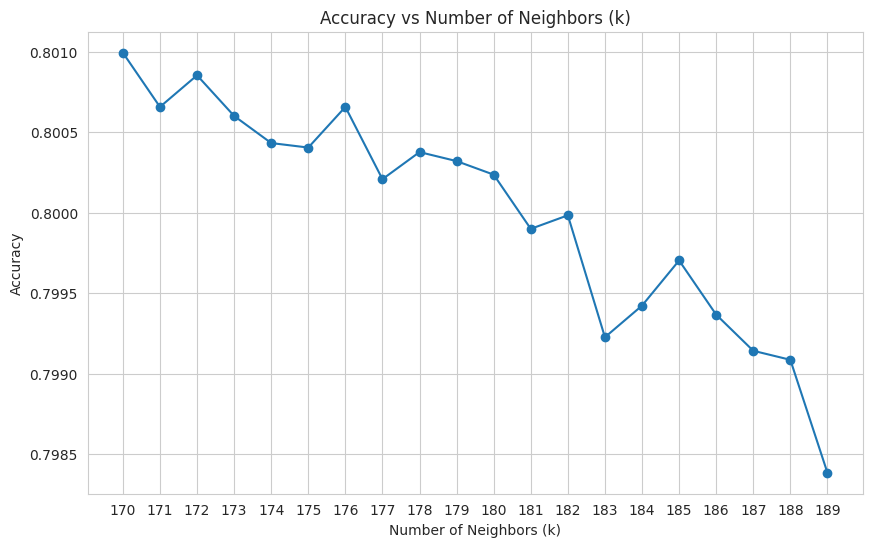

In [ ]:
# Visualize
k_values = list(cv_scores.keys())
accuracy_values = list(cv_scores.values())
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracy_values, marker='o', linestyle='-')
plt.title('Accuracy vs Number of Neighbors (k)')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(range(170, 190))
plt.show()

# In scikit-learn, the convention for scoring functions is that higher values should indicate better performance. However, for metrics like mean squared
# error (MSE), lower values indicate better performance. To adhere to this convention, scikit-learn provides a parameter scoring where you can specify the
# scoring metric. When you use 'neg_mean_squared_error' as the scoring metric, scikit-learn calculates the negative of the mean squared error during
# cross-validation. By doing this, the convention is maintained: higher values (closer to 0) still indicate better performance, and minimizing the negative
# mean squared error is equivalent to minimizing the mean squared error.

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.81      0.87      7641
           1       0.53      0.77      0.63      2132

    accuracy                           0.80      9773
   macro avg       0.73      0.79      0.75      9773
weighted avg       0.84      0.80      0.81      9773

Train Accuracy Score: 0.807107595646808
Test Accuracy Score: 0.803131075411849


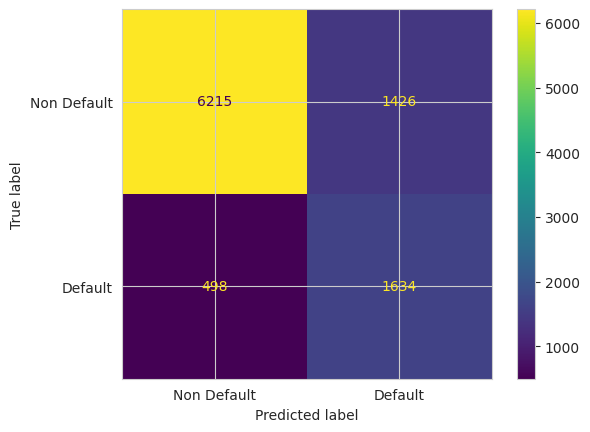

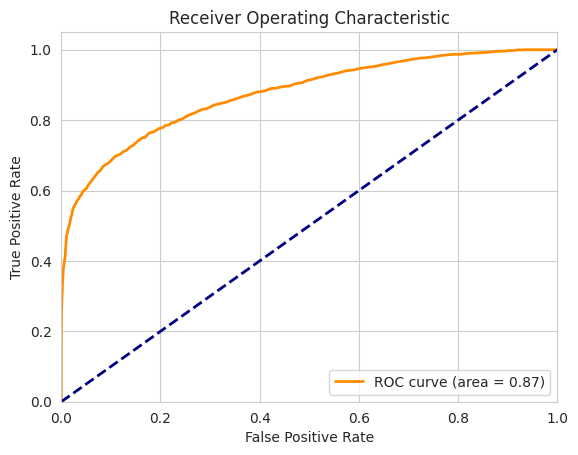

ROC AUC Score: 0.8743255010922855
F1 score (weighted average) is: 0.814
Recall score (class 1) is: 0.766


In [ ]:
evaluate_model(knn_optimal, X_train_smote, X_test_df.to_numpy(), y_train_smote, y_test.to_numpy(), predictions_knn, y_pred_proba_knn)

## Logistic

In [ ]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_smote, y_train_smote)

predictions_lr = logreg.predict(X_test_df)
# Get the prediction probability of the positive class
y_pred_proba_lr = logreg.predict_proba(X_test_df)[:, 1]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names



In [ ]:
# Cross-validation
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer
param_grid = {
    'C': np.linspace(1, 3, 21),
    'penalty': ['l2'],
    'solver': ['lbfgs']
}
grid_search = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_smote, y_train_smote)
print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy found: ", grid_search.best_score_)
best_params = grid_search.best_params_
logreg_optimized = LogisticRegression(**best_params, max_iter=1000)
logreg_optimized.fit(X_train_smote, y_train_smote)

# Make predictions on test data sets
predictions_lr = logreg_optimized.predict(X_test_df)
y_pred_proba_lr = logreg_optimized.predict_proba(X_test_df)[:, 1]

Fitting 5 folds for each of 21 candidates, totalling 105 fits
Best parameters found:  {'C': 2.1, 'penalty': 'l2', 'solver': 'lbfgs'}
Best accuracy found:  0.7944295210273458


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names



Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.80      0.86      7641
           1       0.51      0.76      0.61      2132

    accuracy                           0.79      9773
   macro avg       0.72      0.78      0.73      9773
weighted avg       0.83      0.79      0.80      9773

Train Accuracy Score: 0.7944294850218782
Test Accuracy Score: 0.7888058937890106


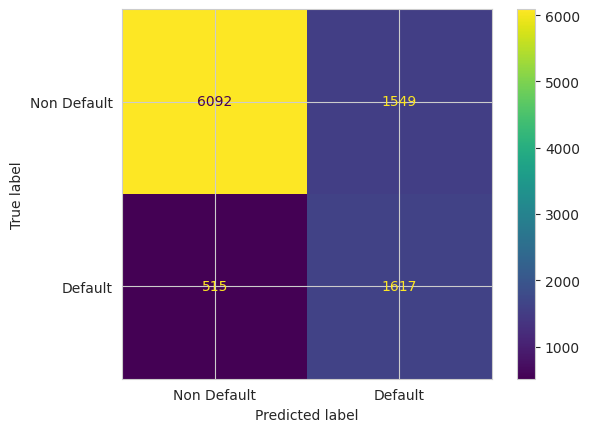

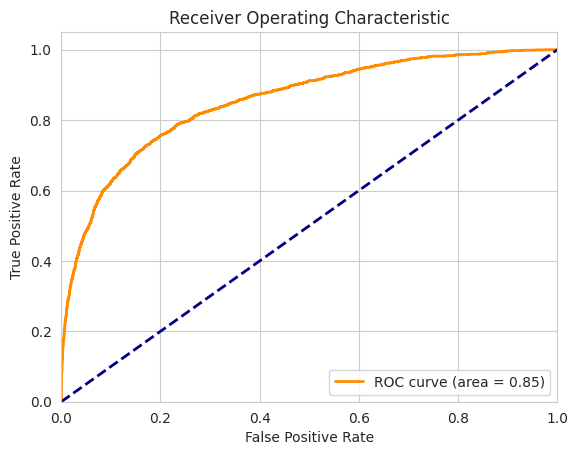

ROC AUC Score: 0.8542230334870169
F1 score (weighted average) is: 0.802
Recall score (class 1) is: 0.758


In [ ]:
# no improvement
evaluate_model(logreg_optimized, X_train_smote, X_test_df, y_train_smote, y_test, predictions_lr, y_pred_proba_lr)

## Decision Tree

In [ ]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train_smote, y_train_smote)

predictions_dtree = dtree.predict(X_test_df)
# Get the prediction probability of the positive class
y_pred_proba_dtree = dtree.predict_proba(X_test_df)[:, 1]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names



In [ ]:
# Cross-validation
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(dtree, param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train_smote, y_train_smote)

print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy found: ", grid_search.best_score_)

best_params = grid_search.best_params_
dtree_optimized = DecisionTreeClassifier(**best_params)
dtree_optimized.fit(X_train_smote, y_train_smote)

predictions_dtree = dtree_optimized.predict(X_test_df)
y_pred_proba_dtree = dtree_optimized.predict_proba(X_test_df)[:, 1]

Best parameters found:  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best accuracy found:  0.9018302719119629


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names



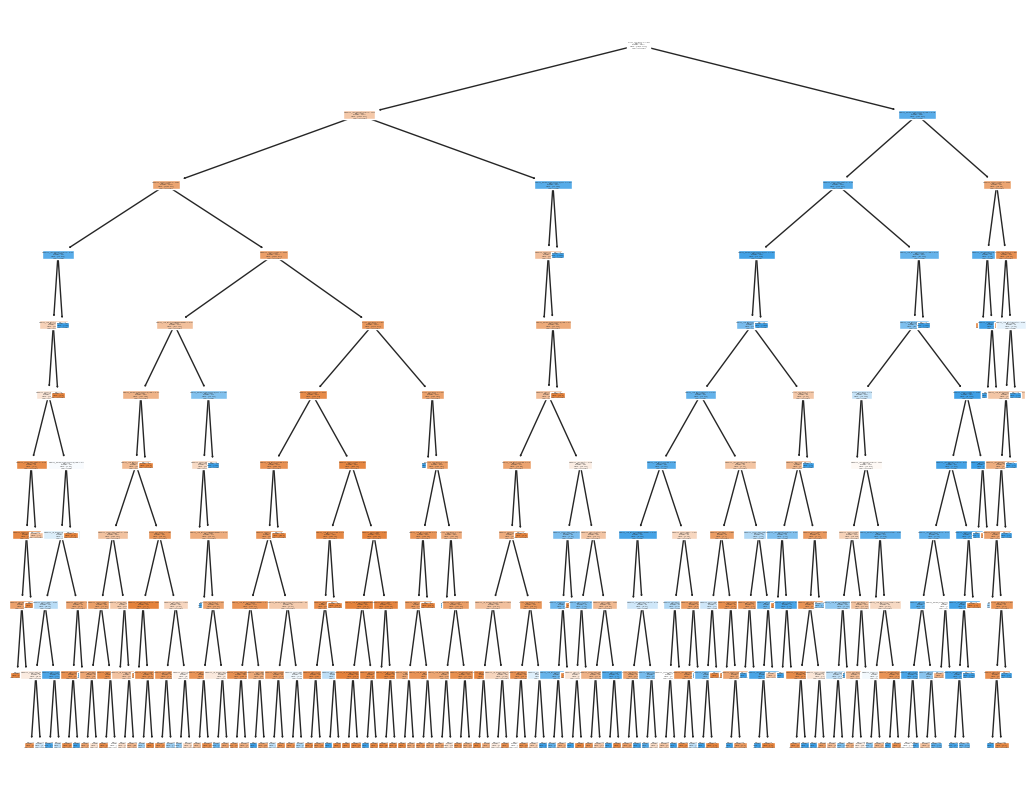

In [ ]:
from sklearn.tree import plot_tree

def get_dt_graph(dt_classifier, X_train_df):
    fig = plt.figure(figsize=(13, 10))
    feature_names = list(X_train_df.columns)
    plot_tree(dt_classifier, filled=True, feature_names=feature_names, class_names=['Not Default', 'Default'])
    plt.show()

get_dt_graph(dtree_optimized, X_train_smote1)

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      7641
           1       0.92      0.72      0.81      2132

    accuracy                           0.93      9773
   macro avg       0.92      0.85      0.88      9773
weighted avg       0.93      0.93      0.92      9773

Train Accuracy Score: 0.9064568607651745
Test Accuracy Score: 0.9252020873836079


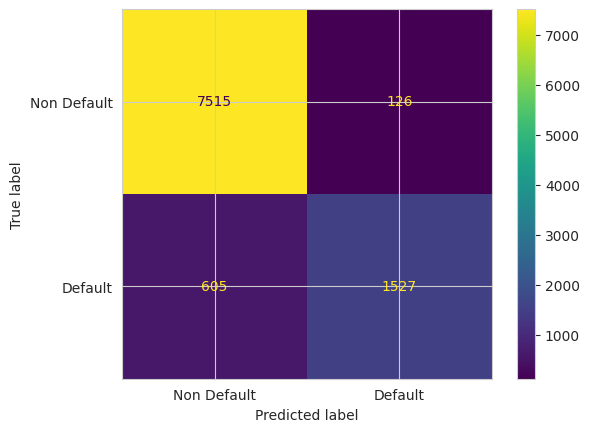

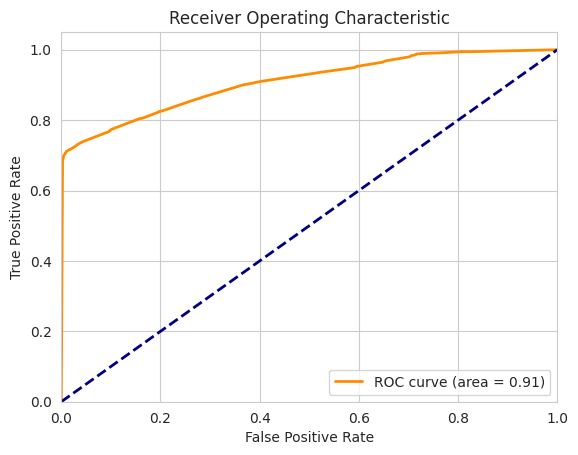

ROC AUC Score: 0.9080781925197162
F1 score (weighted average) is: 0.922
Recall score (class 1) is: 0.716


In [ ]:
# no improvement
evaluate_model(dtree_optimized, X_train_smote, X_test_df, y_train_smote, y_test, predictions_dtree, y_pred_proba_dtree)

## Random Forest

In [ ]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_smote, y_train_smote)

predictions_rf = rf.predict(X_test_df)
y_pred_proba_rf = rf.predict_proba(X_test_df)[:, 1]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names



In [ ]:
# Cross-validation
'''
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(rf, param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train_smote, y_train_smote)

print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy found: ", grid_search.best_score_)
'''
best_params_rf = {
    'max_depth': 10,
    'min_samples_leaf': 1,
    'min_samples_split': 10,
    'n_estimators': 100
}
rf_optimized = RandomForestClassifier(**best_params_rf, random_state=42)

rf_optimized.fit(X_train_smote, y_train_smote)
predictions_rf = rf_optimized.predict(X_test_df)
y_pred_proba_rf = rf_optimized.predict_proba(X_test_df)[:, 1]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names



In [ ]:
# The performance results of the model are trained using default parameters
evaluate_model(rf, X_train_smote, X_test_df, y_train_smote, y_test, predictions_rf, y_pred_proba_rf)

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      7641
           1       0.89      0.73      0.80      2132

    accuracy                           0.92      9773
   macro avg       0.91      0.85      0.88      9773
weighted avg       0.92      0.92      0.92      9773

Train Accuracy Score: 0.9052788062380792
Test Accuracy Score: 0.9212115010743887


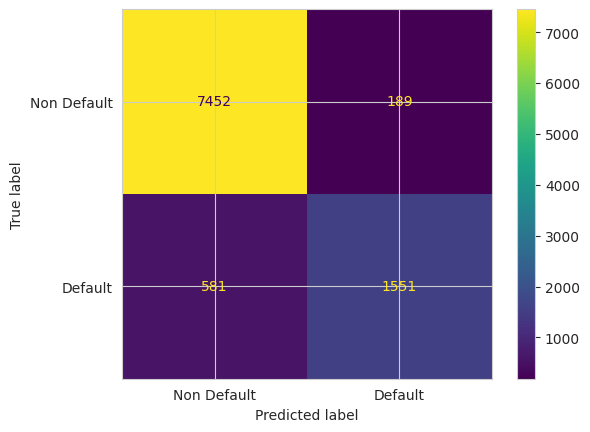

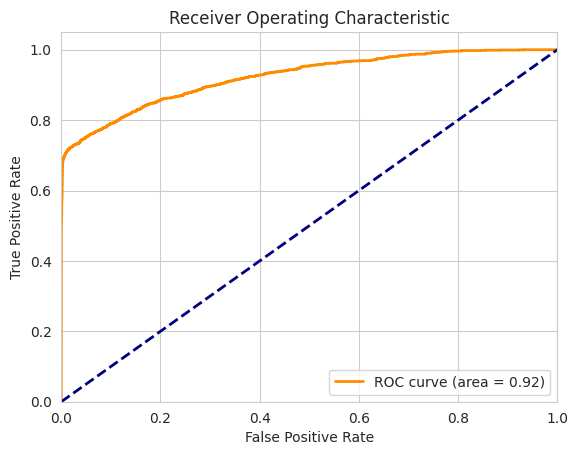

ROC AUC Score: 0.9226120541082188
F1 score (weighted average) is: 0.918
Recall score (class 1) is: 0.727


In [ ]:
# accuracy and AUC are improved after tuning
evaluate_model(rf_optimized, X_train_smote, X_test_df, y_train_smote, y_test, predictions_rf, y_pred_proba_rf)

## XGBoost

In [ ]:
xgb = XGBClassifier(objective='binary:logistic', random_state=42)
xgb.fit(X_train_smote, y_train_smote)

predictions_xgb = xgb.predict(X_test_df)
y_pred_proba_xgb = xgb.predict_proba(X_test_df)[:, 1]

In [ ]:
'''
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.05, 0.1, 0.15, 0.2],
    'max_depth': [3, 5, 7,9],
}
grid_search = GridSearchCV(xgb, param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train_smote, y_train_smote)

print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy found: ", grid_search.best_score_)
'''
best_params_xgb = {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 150}
xgb_optimized = XGBClassifier(objective='binary:logistic', **best_params_xgb, random_state=42)

xgb_optimized.fit(X_train_smote, y_train_smote)
predictions_xgb = xgb_optimized.predict(X_test_df)
y_pred_proba_xgb = xgb_optimized.predict_proba(X_test_df)[:, 1]

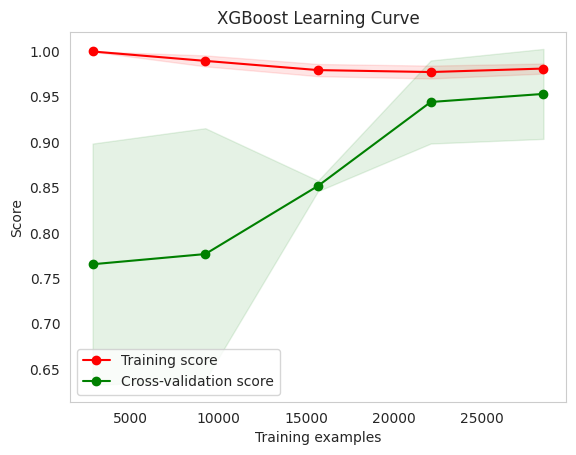

In [ ]:
# XGBoost Learning Curve
from sklearn.model_selection import learning_curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

plot_learning_curve(xgb_optimized, "XGBoost Learning Curve", X_train_smote, y_train_smote, cv=5, n_jobs=-1)
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      7641
           1       0.94      0.74      0.83      2132

    accuracy                           0.93      9773
   macro avg       0.94      0.86      0.89      9773
weighted avg       0.93      0.93      0.93      9773

Train Accuracy Score: 0.9712498597554134
Test Accuracy Score: 0.9329786145502916


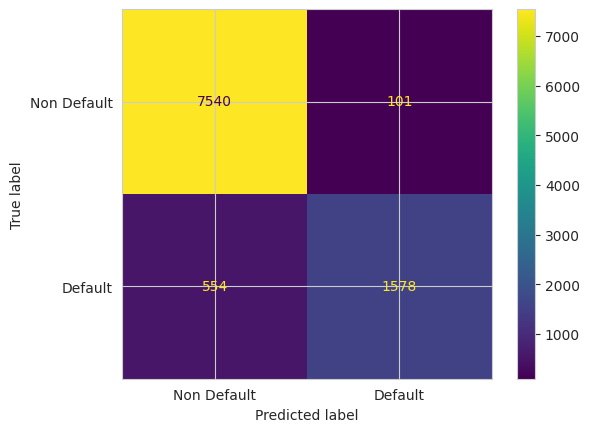

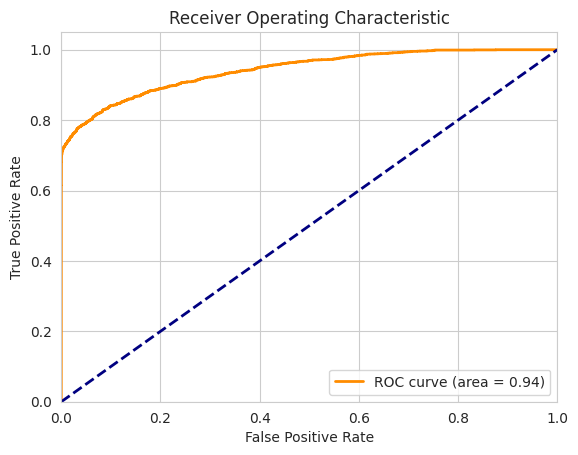

ROC AUC Score: 0.9417144672035649
F1 score (weighted average) is: 0.930
Recall score (class 1) is: 0.740


In [ ]:
# The performance results of the model are trained using default parameters
evaluate_model(xgb, X_train_smote, X_test_df, y_train_smote, y_test, predictions_xgb, y_pred_proba_xgb)

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      7641
           1       0.94      0.74      0.83      2132

    accuracy                           0.93      9773
   macro avg       0.94      0.86      0.89      9773
weighted avg       0.93      0.93      0.93      9773

Train Accuracy Score: 0.9787389206776619
Test Accuracy Score: 0.9329786145502916


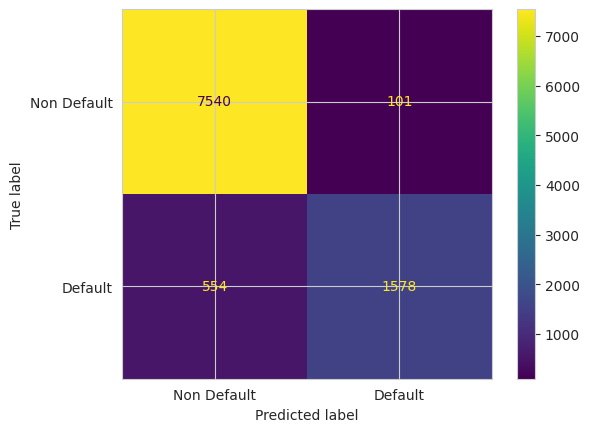

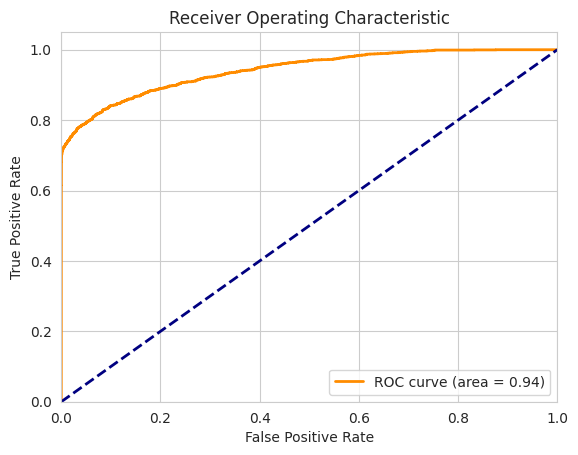

ROC AUC Score: 0.9417144672035649
F1 score (weighted average) is: 0.930
Recall score (class 1) is: 0.740


In [ ]:
# accuracy and AUC are improved after tuning
evaluate_model(xgb_optimized, X_train_smote, X_test_df, y_train_smote, y_test, predictions_xgb, y_pred_proba_xgb)

# Performance summary and evaluation

**In the context of loan default prediction, two key factors come into play: the potential financial impact of missed loan defaults and the risk of denying loans to trustworthy applicants. what we care about most is the accuracy and the recall and F1 scores on 1(default). We care less about precision than recall since, in this particular problem, it is key to identify correctly the biggest number of customers with high default risk. We want to predict default customers with a high number of true positives.**

1- Recall (Sensitivity): Recall measures how well the model identifies actual loan defaults. For lenders, missing a loan that eventually defaults can lead to significant financial losses. Thus, achieving a high Recall is essential because it ensures that most potential default cases are detected, minimizing the risk of financial setbacks.

2- Specificity: Specificity gauges the model's accuracy in identifying loans that won't default. Misclassifying a reliable borrower as a potential defaulter (false positive) can result in lost business opportunities. By emphasizing high Specificity, the model aims to avoid misclassifications that could deny loans to credible applicants.

3- Precision: Precision is a key metric as it evaluates the accuracy of positive predictions. Lenders need to avoid false positives (incorrectly predicting defaults) to prevent unwarranted actions. Maintaining high Precision ensures that when the model predicts a default, it's highly likely to be accurate. This protects the lender from unnecessary costs and safeguards borrower relationships.

F1 Score: The F1 score is a comprehensive performance indicator of the model, combining accuracy and recall. It is a harmonic average of accuracy and recall rates, and provides a comprehensive assessment of the model's ability to classify in both positive categories (defaulting customers) and negative categories (non-defaulting customers). The F1 score indicates the performance of the model when both precision and recall ratio are considered.

Accuracy: Accuracy is the proportion of the number of samples correctly predicted by the model to the total number of samples. In the case of loan default forecasting, accuracy represents the percentage of defaulting and non-defaulting customers that the model correctly predicts. High accuracy means that the model can accurately predict loan defaults and non-defaults.

In [ ]:
def collect_metrics(y_test, y_pred, y_pred_proba):
    accuracy = accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, pos_label=1)
    return accuracy, auc_score, f1, recall

In [ ]:
predictions = {
    'KNN': (predictions_knn, y_pred_proba_knn),
    'Logistic Regression': (predictions_lr, y_pred_proba_lr),
    'Decision Tree': (predictions_dtree, y_pred_proba_dtree),
    'Random Forest': (predictions_rf, y_pred_proba_rf),
    'XGBoost': (predictions_xgb, y_pred_proba_xgb)
}

results = {}
for model_name, (pred, proba) in predictions.items():
    results[model_name] = collect_metrics(y_test, pred, proba)

results_df = pd.DataFrame(results, index=['Accuracy', 'AUC', 'F1 Score', 'Recall']).T
print(results_df)

                     Accuracy       AUC  F1 Score    Recall
KNN                  0.803131  0.874326  0.814361  0.766417
Logistic Regression  0.788806  0.854223  0.801752  0.758443
Decision Tree        0.925202  0.907918  0.921570  0.715291
Random Forest        0.921212  0.922612  0.918208  0.727486
XGBoost              0.932979  0.941714  0.929960  0.740150


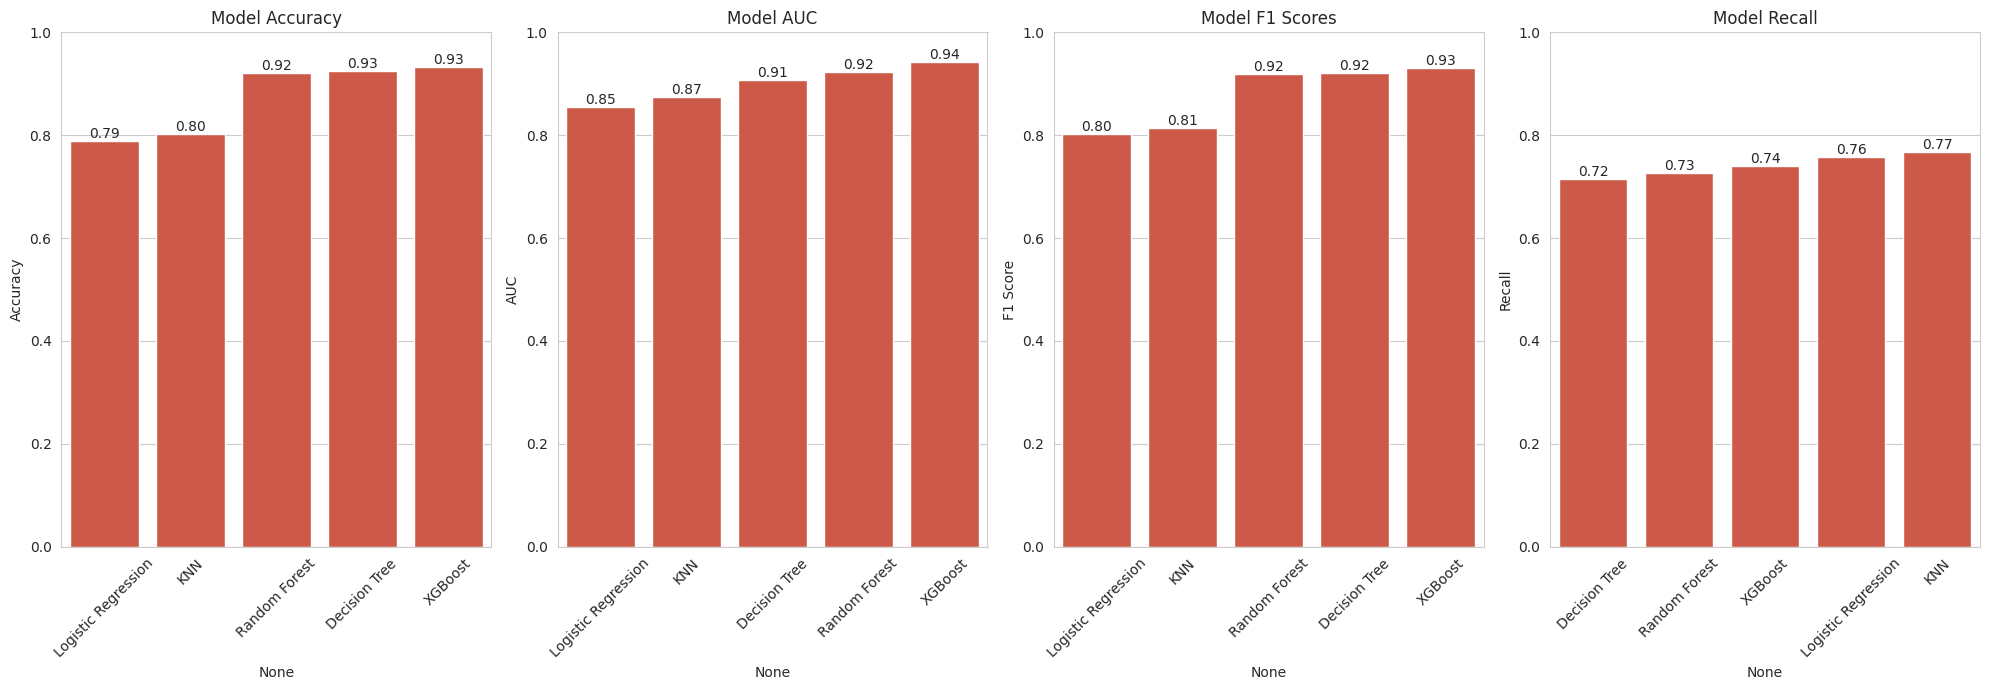

In [ ]:
def plot_evaluation_metrics(results_df):
    """
    Plot evaluation metrics (F1 score, accuracy, AUC, and Recall) as bar plots for each model.

    Parameters:
    results_df (DataFrame): DataFrame containing evaluation metrics for each model.

    Returns:
    None
    """

    # Set color palette
    sns.set_palette('RdYlBu')

    # Set figure size
    plt.figure(figsize=(20, 7))

    # Subplot 2: Accuracy
    sorted_models2 = results_df.sort_values('Accuracy', ascending=True).index.tolist()
    plt.subplot(1, 4, 1)
    ax_acc = sns.barplot(x=results_df.index, y='Accuracy', order=sorted_models2, data=results_df)
    plt.title('Model Accuracy')
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    ax_acc.bar_label(ax_acc.containers[0], fmt='%.2f')

    # Subplot 3: AUC
    sorted_models3 = results_df.sort_values('AUC', ascending=True).index.tolist()
    plt.subplot(1, 4, 2)
    ax_auc = sns.barplot(x=results_df.index, y='AUC', order=sorted_models3, data=results_df)
    plt.title('Model AUC')
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    ax_auc.bar_label(ax_auc.containers[0], fmt='%.2f')

    # Subplot 1: F1 Scores
    sorted_models1 = results_df.sort_values('F1 Score', ascending=True).index.tolist()
    plt.subplot(1, 4, 3)
    ax_f1 = sns.barplot(x=results_df.index, y='F1 Score', order=sorted_models1, data=results_df)
    plt.title('Model F1 Scores')
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    ax_f1.bar_label(ax_f1.containers[0], fmt='%.2f')

    # Subplot 4: Recall
    sorted_models4 = results_df.sort_values('Recall', ascending=True).index.tolist()
    plt.subplot(1, 4, 4)
    ax_recall = sns.barplot(x=results_df.index, y='Recall', order=sorted_models4, data=results_df)
    plt.title('Model Recall')
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    ax_recall.bar_label(ax_recall.containers[0], fmt='%.2f')

    # Adjust layout
    plt.tight_layout()
    plt.show()
plot_evaluation_metrics(results_df)

Accuracy: Measures the proportion of correct predictions made by the model. XGBoost scores the highest on this metric (0.932979), indicating it's the most accurate among all models.

AUC (Area Under the Curve): Reflects the model's ability to distinguish between positive and negative classes across all possible classification thresholds. XGBoost achieves the highest AUC value (0.941714), indicating its strong predictive power for credit default.

F1 Score: Harmonic mean of precision and recall, particularly useful in situations with imbalanced data. XGBoost achieves the highest F1 score (0.929960), indicating a good balance between precision and recall.

Recall: Measures the model's ability to identify positive cases. While XGBoost doesn't have the highest recall (0.740150), its performance remains superior compared to other models.

Based on the above analysis, XGBoost emerges as the best choice due to its strong performance across most key metrics. Particularly in scenarios like credit default prediction where consequences can be severe, selecting a model with the best overall performance is crucial. XGBoost's robust performance is attributed partly to its gradient boosting mechanism, which effectively handles various types of data distributions, including imbalanced datasets common in credit default prediction.

However, model selection isn't solely based on performance metrics; it also considers business needs, operational costs, and end-user requirements. If business processes demand explanations for each prediction decision, opting for a simpler model like logistic regression might be necessary, despite potentially suboptimal performance metrics.

Future Improvements:

Recall is especially crucial because the cost of missing defaults (e.g., lost loans) outweighs the cost of false positives (e.g., missed loan opportunities). Hence, cost-sensitive learning techniques can be employed, where different error costs are introduced to the model. Assigning a higher cost to misclassifying default cases as non-default (false negatives) encourages the model to focus more on positive cases during training.

Sample Weight Adjustment: Assigning different weights to each loan in the training data based on factors such as loan size or the financial impact of default can be beneficial. Larger loans or high-risk loans might require higher weights, encouraging the model to accurately classify these loans.

Feature Engineering: Further analysis and engineering of features could provide additional insights. Creating new features, selecting highly correlated features, or transforming features might help improve model performance.

Hyperparameter Tuning: For complex models like XGBoost, hyperparameters significantly affect model performance. Using a broader search range, finer grid search, or advanced methods like Bayesian optimization can help find the best hyperparameter combination. This may enhance the model's performance across various metrics, including recall.

ROC curves should be used when there are roughly equal numbers of observations for each class.
Precision-Recall curves should be used when there is a moderate to large class imbalance

Plotting the ROC Curve and calculating AUC:¶

The AUC-ROC metric helps determine and tell us about the capability of a model in distinguishing the classes. The judging criteria being - Higher the AUC, better the model.

The ROC curve depicts the rate of true positives with respect to the rate of false positives, therefore highlighting the sensitivity of the classifier model.

AUC of a classifier is equal to the probability that the classifier will rank a randomly chosen positive example higher than that of a randomly chosen negative example. The Area Under the Curve provides the ability for a classifier to distinguish between classes and is used as a summary of the ROC curve. The higher the AUC, it is assumed that the better the performance of the model at distinguishing between the positive and negative classes.

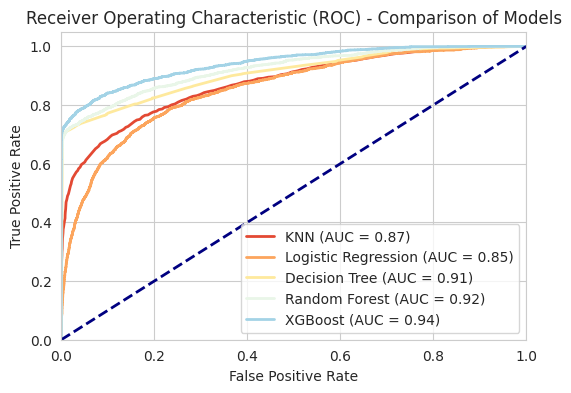

In [ ]:
plt.figure(figsize=(6, 4))

# Calculate and plot ROC curves for each model
for model_name, (y_pred, y_pred_proba) in predictions.items():
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Comparison of Models')
plt.legend(loc="lower right")

plt.show()

# Boostrap

Boostrap (self-sampling) is performed on each model to determine the average indicator performance: For each model, the model is trained by multiple samples, and then the average indicator is calculated to evaluate the model's performance more accurately

In [ ]:
from sklearn.utils import resample
models = {
    'KNN': knn_optimal,
    'Logistic Regression': logreg_optimized,
    'Decision Tree': dtree_optimized,
    'Random Forest': rf_optimized,
    'XGBoost': xgb_optimized
}
# Define the Bootstrap parameter
n_iterations = 1000
n_size = int(len(X_train_smote))

bootstrap_results = {name: {'Accuracy': [], 'AUC': [], 'F1 Score': [], 'Recall': []} for name in models.keys()}

# Bootstrap
for model_name, model in models.items():
    for i in range(n_iterations):
        # Prepare Bootstrap samples for training and testing sets
        X_train_boot, y_train_boot = resample(X_train_smote, y_train_smote, n_samples=n_size)
        model.fit(X_train_boot, y_train_boot)
        y_pred = model.predict(X_test_df)
        y_pred_proba = model.predict_proba(X_test_df)[:, 1]

        accuracy, auc_score, f1, recall = collect_metrics(y_test, y_pred, y_pred_proba)
        bootstrap_results[model_name]['Accuracy'].append(accuracy)
        bootstrap_results[model_name]['AUC'].append(auc_score)
        bootstrap_results[model_name]['F1 Score'].append(f1)
        bootstrap_results[model_name]['Recall'].append(recall)

results_mean_std = {}
for model_name, metrics in bootstrap_results.items():
    results_mean_std[model_name] = {}
    for metric_name, scores in metrics.items():
        mean = np.mean(scores)
        results_mean_std[model_name][metric_name] = f"{mean:.5f}"

results_df_formatted = pd.DataFrame(results_mean_std).T

In [ ]:
results_df_formatted = pd.DataFrame({
    'Accuracy': [0.80148, 0.78828, 0.92076, 0.91965, 0.93016],
    'AUC': [0.87244, 0.85408, 0.90187, 0.92151, 0.93729],
    'F1 Score': [0.81290, 0.80125, 0.91745, 0.91667, 0.92710],
    'Recall': [0.76539, 0.75693, 0.71862, 0.72607, 0.73607]
}, index=['KNN', 'Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost'])

results_df_formatted

In [ ]:
def plot_evaluation_metrics_fixed(results_df_formatted):
    """
    Plot evaluation metrics (Accuracy, AUC, F1 Score, and Recall) as separate bar plots for each model,
    sorted by each metric from low to high.

    Parameters:
    results_df (DataFrame): DataFrame containing evaluation metrics for each model.

    Returns:
    None
    """

    # Set color palette
    sns.set_palette('RdYlBu')

    # Set figure size
    plt.figure(figsize=(35, 13))

    # Plot Accuracy
    sorted_df = results_df.sort_values('Accuracy', ascending=True)
    plt.subplot(1, 4, 1)
    ax_acc = sns.barplot(x=sorted_df['Accuracy'], y=sorted_df.index, data=sorted_df)
    plt.title('Model Accuracy')
    plt.xlim(0, 1)
    ax_acc.bar_label(ax_acc.containers[0], fmt='%.2f')

    # Plot AUC
    sorted_df = results_df.sort_values('AUC', ascending=True)
    plt.subplot(1, 4, 2)
    ax_auc = sns.barplot(x=sorted_df['AUC'], y=sorted_df.index, data=sorted_df)
    plt.title('Model AUC')
    plt.xlim(0, 1)
    ax_auc.bar_label(ax_auc.containers[0], fmt='%.2f')

    # Plot F1 Score
    sorted_df = results_df.sort_values('F1 Score', ascending=True)
    plt.subplot(1, 4, 3)
    ax_f1 = sns.barplot(x=sorted_df['F1 Score'], y=sorted_df.index, data=sorted_df)
    plt.title('Model F1 Scores')
    plt.xlim(0, 1)
    ax_f1.bar_label(ax_f1.containers[0], fmt='%.2f')

    # Plot Recall
    sorted_df = results_df.sort_values('Recall', ascending=True)
    plt.subplot(1, 4, 4)
    ax_recall = sns.barplot(x=sorted_df['Recall'], y=sorted_df.index, data=sorted_df)
    plt.title('Model Recall')
    plt.xlim(0, 1)
    ax_recall.bar_label(ax_recall.containers[0], fmt='%.2f')

    # Adjust layout
    plt.tight_layout()
    plt.show()
plot_evaluation_metrics_fixed(results_df_formatted)